In [163]:
import numpy
import scipy.io
import math
import matplotlib.pyplot as plt
from collections import Counter
mat = scipy.io.loadmat('dset.mat')
C = 10

In [128]:
def task1_1(X, Y):
    N = len(X)
    D = len(X[0])
    
    x_bar = X.sum((0,))/N
    
    X_st = [numpy.asmatrix(x-x_bar) for x in X]
    S = sum([(x.transpose()@x).A for x in X_st])/N
    scipy.io.savemat('t1_S.mat', dict(S=S))
    
    sqrtd_vrns = [math.sqrt(S.item(i,i)) for i in range(D)]
    
    R = [
        S[i] / sqrtd_vrns / sqrtd_vrns[i]
        for i in range(D)
    ]
    
    scipy.io.savemat('t1_R.mat', dict(R=R))

[(1, 2), (11, 12), (18, 19)]


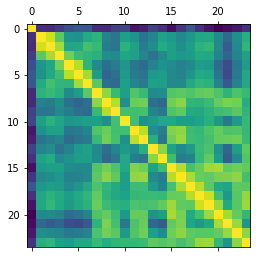

In [129]:
# task 1_2
task1_1(mat['X'], mat['Y_species'])
test_mat = scipy.io.loadmat('t1_R.mat')
R = test_mat['R']
#print(R)
plt.matshow(R)
D = len(R)
print([(i,j) for i in range (D) for j in range(D) if (i < j and abs(R.item(i,j))>0.85)])
plt.show()

In [130]:

def listToColV(li):
    return numpy.asarray(li).reshape(-1,1)

def task1_3(Cov):
    D = len(Cov)
    EVals_orig, EVecs_orig = numpy.linalg.eig(Cov)

    sorted_evals = sorted(zip(EVals_orig, range(D)), reverse=True)
    EVals = [EVals_orig[i] for (_,i) in sorted_evals]

    def norm_EV(v):
        if v.item(0) > 0:
            return v
        else:
            return -v
    
    EVecs = [norm_EV(EVecs_orig[i]) for (_,i) in sorted_evals]

    scipy.io.savemat('t1_EVecs.mat', dict(EVecs=(numpy.asarray(EVecs).T)))
    scipy.io.savemat('t1_EVals.mat', dict(EVals=listToColV(EVals)))

    Cumvar = [sum(EVals[:(i+1)]) for i in range(D)]
    scipy.io.savemat('t1_Cumvar.mat', dict(Cumvar=listToColV(Cumvar)))

    def calcMinDims(variance_ratio):
        total_var = Cumvar[-1]
        indexed_Cumvar = zip(Cumvar, range(D))
        return min(
            [i+1 for (cv, i) in indexed_Cumvar \
                 if cv >= total_var * variance_ratio]
        )

    MinDims = [calcMinDims(perc/100) for perc in [70,80,90,95]]
    scipy.io.savemat('t1_MinDims.mat', dict(MinDims=listToColV(MinDims)))

In [131]:
S = scipy.io.loadmat('t1_S.mat')['S']
task1_3(S)
testmat = scipy.io.loadmat('t1_MinDims.mat')['MinDims']
print(testmat)

[[ 3]
 [ 5]
 [ 7]
 [10]]


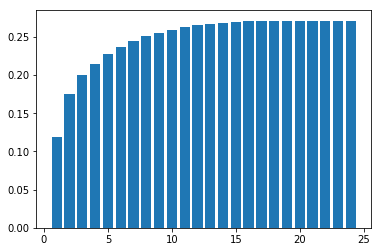

In [132]:
# 1.3b)
Cumvar_mat = scipy.io.loadmat('t1_Cumvar.mat')['Cumvar']
Cumvar = [x[0] for x in Cumvar_mat.tolist()]
plt.bar(range(1, len(Cumvar)+1), Cumvar)
#plt.bar()), Cumvar.tolist()) 
plt.savefig('task1_3b_cumvar_graph.png')
plt.show()

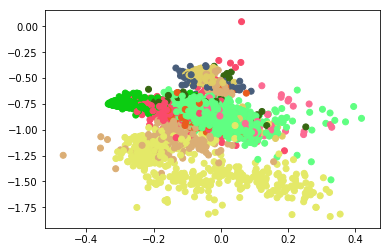

In [164]:
# 1.3c)
def task_1_3_c():
    X = mat['X']
    eigenvecs_cols = scipy.io.loadmat('t1_EVecs.mat')['EVecs']
    u = eigenvecs_cols[:,0].reshape(-1, 1)
    v = eigenvecs_cols[:,1].reshape(-1, 1)
    Y_n = numpy.matmul(X, u)
    Z_n = numpy.matmul(X, v)

    Y_species = mat['Y_species']
    class_colours = numpy.random.rand(C,3).tolist()
    colour_by_index = [class_colours[Y_species.item(i,0)-1]
                           for i in range(len(Y_n))]
    plt.scatter([y[0] for y in Y_n], 
                [z[0] for z in Z_n],
                c=colour_by_index
    )
    plt.savefig('task1_3c_scatter_classes.png')
    plt.show()
    

task_1_3_c()

In [182]:
def task1_mgc_cv(X, Y, CovKind, epsilon, Kfolds):
    class_freq = Counter(Y.T.tolist()[0])
    
    def Mc(class_num):
        return class_freq[class_num]//Kfolds
    
    current_class_partition = dict((i,1) for i in range(1,C+1))
    current_class_left = dict((i,Mc(i)) for i in range(1, C+1))
    
    PMap = []
    
    for i in range(len(Y)):
        class_num = Y.item(i,0) 
        
        # switch to next partition if no samples left
        if current_class_left[class_num] == 0 and \
                current_class_partition[class_num] != Kfolds:
            
            current_class_partition[class_num] += 1
            current_class_left[class_num] = Mc(class_num)
        
        PMap.append(current_class_partition[class_num])
        current_class_left[class_num] -= 1
        
    # ask if this really should be the file name, 
        # as we need to submit it for each CovKind
    scipy.io.savemat(f't1_mgc_{Kfolds}cv_PMap.mat', 
                     dict(PMap=listToColV(PMap)))      

In [183]:
for CovKind in [1,2,3]:
    task1_mgc_cv(mat['X'], mat['Y_species'], CovKind, 0.01, 5)